In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [2]:
sample_df = pd.read_csv("train.csv")

In [3]:
sample_df.shape

(1048575, 11)

In [4]:
sample_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,14-03-2016 17:24,14-03-2016 17:32,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,12-06-2016 00:43,12-06-2016 00:54,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,19-01-2016 11:35,19-01-2016 12:10,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,06-04-2016 19:32,06-04-2016 19:39,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,26-03-2016 13:30,26-03-2016 13:38,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
sample_df["store_and_fwd_flag"].value_counts()

N    1042766
Y       5809
Name: store_and_fwd_flag, dtype: int64

In [6]:
 
f = lambda x: 0 if x == 'N' else 1

sample_df["store_and_fwd_flag"] = sample_df["store_and_fwd_flag"].apply(lambda x: f(x))            

In [7]:
#Check result
sample_df["store_and_fwd_flag"].value_counts()

0    1042766
1       5809
Name: store_and_fwd_flag, dtype: int64

In [8]:
#First, convert datetime strings into datetime
sample_df["dropoff_datetime"] = pd.to_datetime(sample_df["dropoff_datetime"], format='%d-%m-%Y %H:%M')
sample_df["pickup_datetime"] = pd.to_datetime(sample_df["pickup_datetime"], format='%d-%m-%Y %H:%M')

In [9]:

sample_df["pickup_month"] = sample_df["pickup_datetime"].dt.month
sample_df["pickup_day"] = sample_df["pickup_datetime"].dt.day
sample_df["pickup_weekday"] = sample_df["pickup_datetime"].dt.weekday 
sample_df["pickup_hour"] = sample_df["pickup_datetime"].dt.hour
sample_df["pickup_minute"] = sample_df["pickup_datetime"].dt.minute

In [10]:
#Get latitude and longitude differences 
sample_df["latitude_difference"] = sample_df["dropoff_latitude"] - sample_df["pickup_latitude"]
sample_df["longitude_difference"] = sample_df["dropoff_longitude"] - sample_df["pickup_longitude"]

In [11]:
#Convert duration to minutes for easier interpretation
sample_df["trip_duration"] = sample_df["trip_duration"].apply(lambda x: round(x/60))

In [12]:
sample_df.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute,latitude_difference,longitude_difference
0,id2875421,2,2016-03-14 17:24:00,2016-03-14 17:32:00,1,-73.982155,40.767937,-73.96463,40.765602,0,8,3,14,0,17,24,-0.002335,0.017525


In [13]:
#Convert trip distance from longitude and latitude differences to distance format.(|x1-x2| + |y1-y2|)
sample_df["trip_distance"] = 0.621371 * 6371 * (abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(sample_df["latitude_difference"]) * np.pi / 180) / 2))), 
                                  np.sqrt(1-(np.square(np.sin((abs(sample_df["latitude_difference"]) * np.pi / 180) / 2)))))) + \
                                     abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(sample_df["longitude_difference"]) * np.pi / 180) / 2))), 
                                  np.sqrt(1-(np.square(np.sin((abs(sample_df["longitude_difference"]) * np.pi / 180) / 2)))))))

In [14]:
sample_df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute,latitude_difference,longitude_difference,trip_distance
0,id2875421,2,2016-03-14 17:24:00,2016-03-14 17:32:00,1,-73.982155,40.767937,-73.964630,40.765602,0,8,3,14,0,17,24,-0.002335,0.017525,1.372146
1,id2377394,1,2016-06-12 00:43:00,2016-06-12 00:54:00,1,-73.980415,40.738564,-73.999481,40.731152,0,11,6,12,6,0,43,-0.007412,-0.019066,1.829440
2,id3858529,2,2016-01-19 11:35:00,2016-01-19 12:10:00,1,-73.979027,40.763939,-74.005333,40.710087,0,35,1,19,1,11,35,-0.053852,-0.026306,5.538398
3,id3504673,2,2016-04-06 19:32:00,2016-04-06 19:39:00,1,-74.010040,40.719971,-74.012268,40.706718,0,7,4,6,2,19,32,-0.013252,-0.002228,1.069568
4,id2181028,2,2016-03-26 13:30:00,2016-03-26 13:38:00,1,-73.973053,40.793209,-73.972923,40.782520,0,7,3,26,5,13,30,-0.010689,0.000130,0.747485


In [15]:
weather_df = pd.read_csv("KNYC_Metars.csv")

In [16]:
weather_df.head()

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast
3,2015-12-31 05:00:00,7.2,5.9,NaN,0.86,1015.9,5.0,14.5,NW,7.4,0.0,0.0,None,Overcast
4,2015-12-31 06:00:00,7.2,6.4,NaN,0.90,1016.2,5.6,11.3,West,5.6,0.0,0.0,None,Overcast


In [17]:
weather_df["Time"] = pd.to_datetime(weather_df["Time"])
weather_df["pickup_year"] = weather_df["Time"].dt.year
weather_df["pickup_month"] = weather_df["Time"].dt.month
weather_df["pickup_day"] = weather_df["Time"].dt.day
weather_df["pickup_hour"] = weather_df["Time"].dt.hour

In [18]:
weather_df.head(2)

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions,pickup_year,pickup_month,pickup_day,pickup_hour
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast,2015,12,31,2
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast,2015,12,31,3


In [19]:

weather_df = weather_df[weather_df["pickup_year"] == 2016]
weather_df.head(2)

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions,pickup_year,pickup_month,pickup_day,pickup_hour
22,2016-01-01 00:00:00,5.6,3.2,NaN,0.58,1018.8,-2.2,16.1,WNW,11.1,0.0,0.0,None,Overcast,2016,1,1,0
23,2016-01-01 01:00:00,5.6,4.0,NaN,0.53,1018.5,-3.3,16.1,Variable,7.4,0.0,0.0,None,Overcast,2016,1,1,1


In [20]:
#Merge weather data with my dataframe
sample_df = pd.merge(sample_df, weather_df[["Temp.", "pickup_month", "pickup_day", "pickup_hour", "Windchill", 
                                            "Humidity", "Pressure", "Dew Point", "Visibility", "Wind Dir", 
                                            "Wind Speed", "Gust Speed", "Precip", "Conditions"]], 
                                             how = "left", on = ["pickup_month", "pickup_day", "pickup_hour"])

In [21]:
sample_df.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute,latitude_difference,longitude_difference,trip_distance,Temp.,Windchill,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Conditions
0,id2875421,2,2016-03-14 17:24:00,2016-03-14 17:32:00,1,-73.982155,40.767937,-73.964630,40.765602,0,8,3,14,0,17,24,-0.002335,0.017525,1.372146,4.4,-0.5,0.86,1017.5,2.2,8.0,ENE,27.8,57.4,0.3,Overcast
1,id2377394,1,2016-06-12 00:43:00,2016-06-12 00:54:00,1,-73.980415,40.738564,-73.999481,40.731152,0,11,6,12,6,0,43,-0.007412,-0.019066,1.829440,28.9,NaN,0.53,1006.6,18.3,16.1,West,7.4,0.0,0.0,Unknown
2,id3858529,2,2016-01-19 11:35:00,2016-01-19 12:10:00,1,-73.979027,40.763939,-74.005333,40.710087,0,35,1,19,1,11,35,-0.053852,-0.026306,5.538398,-6.7,-14.3,0.46,1016.3,-16.7,16.1,West,24.1,46.3,0.0,Clear


In [22]:
#Look at weather conditions
sample_df["Conditions"].unique()

array(['Overcast', 'Unknown', 'Clear', 'Heavy Rain', nan, 'Haze',
       'Partly Cloudy', 'Mostly Cloudy', 'Light Rain', 'Light Snow',
       'Scattered Clouds', 'Snow', 'Rain', 'Heavy Snow',
       'Light Freezing Rain'], dtype=object)

In [23]:
#Codify weather conditions into buckets
sample_df["Conditions"] = sample_df["Conditions"].fillna('Unknown')

weather_dict = {'Overcast' : 0, 
                'Haze' : 0,
                'Partly Cloudy' : 0, 
                'Mostly Cloudy' : 0, 
                'Scattered Clouds' : 0, 
                'Light Freezing Fog' : 0,
                
                'Unknown' : 1,
                'Clear' : 2, 
                
                'Heavy Rain' : 3, 
                'Rain' : 3, 
                'Light Freezing Rain' : 3,
                'Light Rain' : 3, 
                
                'Heavy Snow' : 4,
                'Light Snow' : 4,
                'Snow' : 4}

In [24]:
#Transform the column
sample_df["Conditions"] = sample_df["Conditions"].apply(lambda x: weather_dict[x])            

In [25]:
#Look at wind directions
sample_df["Wind Dir"].unique()

array(['ENE', 'West', 'South', 'Variable', 'SW', 'Calm', 'North', 'WSW',
       'East', nan, 'WNW', 'NW', 'ESE', 'NE', 'SSW', 'SSE', 'SE', 'NNE',
       'NNW'], dtype=object)

In [26]:
#Codify wind directions
sample_df["Wind Dir"] = sample_df["Wind Dir"].fillna('Unknown')

wind_dir_dict = {'East' : 0,
                 'ENE' : 0, 
                 'ESE' : 0, 
                 
                 'West' : 1, 
                 'WSW' : 1,
                 'WNW' : 1,
                 
                 'South' : 2, 
                 'SSE' : 2,   
                 'SSW' : 2,
                 
                 'North' : 3, 
                 'NNE' : 3, 
                 'NNW' : 3,
                 
                 'Variable' : 4, 
                 'Calm' : 5, 
                 'SW' : 6, 
                 'NW' : 7, 
                 'NE' : 8, 
                 'SE' : 9, 
                 'Unknown' : 10
                }

In [27]:
#And transform the column
sample_df["Wind Dir"] = sample_df["Wind Dir"].apply(lambda x: wind_dir_dict[x]) 

In [28]:
#Check results
sample_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute,latitude_difference,longitude_difference,trip_distance,Temp.,Windchill,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Conditions
0,id2875421,2,2016-03-14 17:24:00,2016-03-14 17:32:00,1,-73.982155,40.767937,-73.964630,40.765602,0,8,3,14,0,17,24,-0.002335,0.017525,1.372146,4.4,-0.5,0.86,1017.5,2.2,8.0,0,27.8,57.4,0.3,0
1,id2377394,1,2016-06-12 00:43:00,2016-06-12 00:54:00,1,-73.980415,40.738564,-73.999481,40.731152,0,11,6,12,6,0,43,-0.007412,-0.019066,1.829440,28.9,NaN,0.53,1006.6,18.3,16.1,1,7.4,0.0,0.0,1
2,id3858529,2,2016-01-19 11:35:00,2016-01-19 12:10:00,1,-73.979027,40.763939,-74.005333,40.710087,0,35,1,19,1,11,35,-0.053852,-0.026306,5.538398,-6.7,-14.3,0.46,1016.3,-16.7,16.1,1,24.1,46.3,0.0,2
3,id3504673,2,2016-04-06 19:32:00,2016-04-06 19:39:00,1,-74.010040,40.719971,-74.012268,40.706718,0,7,4,6,2,19,32,-0.013252,-0.002228,1.069568,7.2,3.3,0.39,1019.1,-6.1,16.1,2,25.9,35.2,0.0,2
4,id2181028,2,2016-03-26 13:30:00,2016-03-26 13:38:00,1,-73.973053,40.793209,-73.972923,40.782520,0,7,3,26,5,13,30,-0.010689,0.000130,0.747485,9.4,NaN,0.46,1026.9,-1.7,16.1,4,9.3,0.0,0.0,2


In [29]:
X = sample_df.drop(["trip_duration", "id", "vendor_id", "pickup_datetime", "dropoff_datetime"], axis=1)
y = sample_df["trip_duration"]

In [30]:
#Split the data into training, test, and valdiation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.35, random_state=2019)

In [31]:
#Define evaluation metric
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

In [32]:
#XGBoost parameters 
params = {
    'booster':            'gbtree',
    'fobj':               'reg:linear',
    'learning_rate':      0.1,
    'max_depth':          14,
    'subsample':          0.9,
    'colsample_bytree':   0.7,
    'colsample_bylevel':  0.7,
    'verbose_eval' :      1,
    'feval':              'rmsle'
}

In [33]:
nrounds = 1300

In [34]:
#Define train and validation sets
dtrain = lgb.Dataset(X_train, np.log(y_train+1))
dval = lgb.Dataset(X_val, np.log(y_val+1), reference=dtrain)

#this is for tracking the error
watchlist = [(dtrain, 'train'), (dval, 'eval')]

In [35]:
#Train model
bst = lgb.train(params,
                dtrain,
                num_boost_round = nrounds,
                valid_sets = [dtrain, dval],
                valid_names = ['train', 'valid'],
                categorical_feature = [20, 24]
                )

C:\Users\Deejaey\anaconda3\lib\site-packages\lightgbm\basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [20, 24]
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Unknown parameter: feval
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: fobj
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: feval
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: fobj
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075712 seconds.
You can set `force_col_wise=true` to remove the overh

C:\Users\Deejaey\anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\Deejaey\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.486080


In [36]:
#Test predictions
pred = np.exp(bst.predict(X_test)) - 1

In [37]:
#Use mean absolute error to get a basic estimate of the error
mae = (abs(pred - y_test)).mean()
mae

5.027245070288294

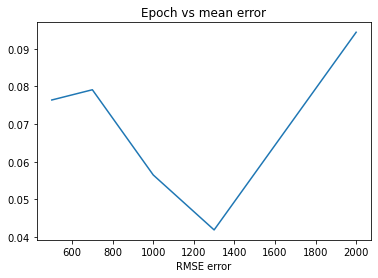

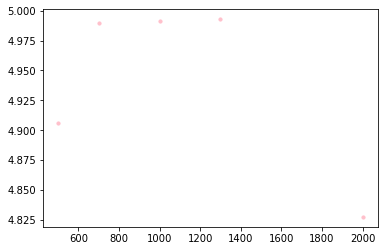

In [7]:
import matplotlib.pyplot as plt 

#line graph
a = [500,700,1000,1300,2000] 
b = [0.07641,0.07913,0.0565,0.04191,0.0944] 
plt.plot(a,b)
plt.title("Epoch vs mean error")
plt.xlabel("epoch")
plt.xlabel("RMSE error")
plt.show() 

